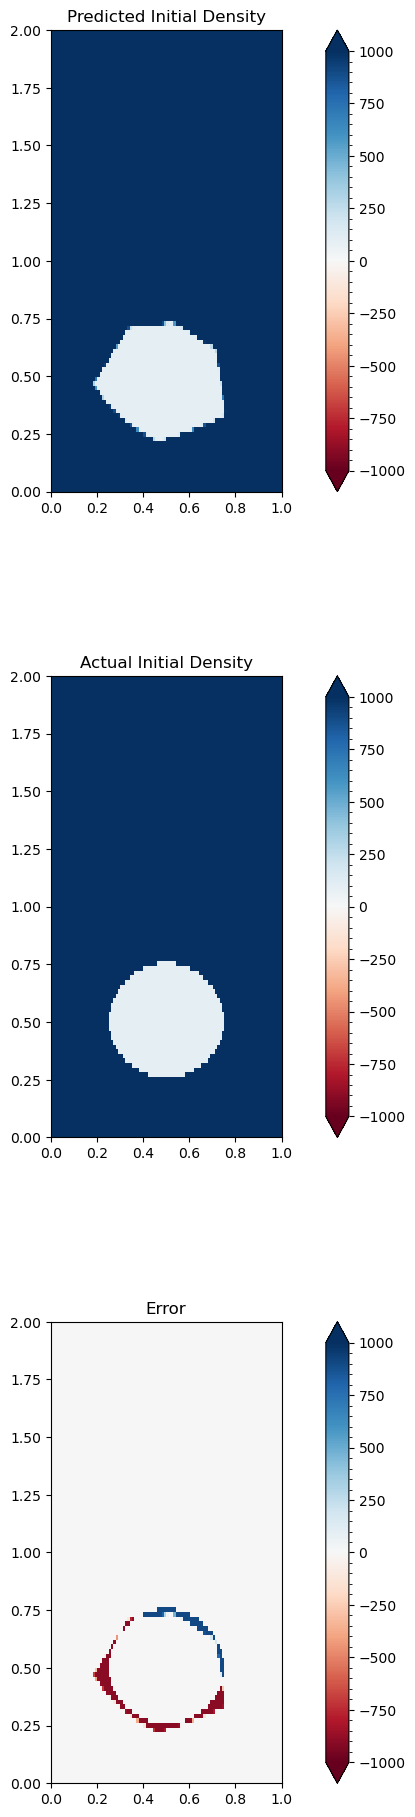

In [1]:
import torch
from torch import nn
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt

from Forward_with_Layer_Setting import Net
from InitialConditionLoss import InitialCondition_phi

###########################################

time_plotted = 0

###########################################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net().to(device)

net.load_state_dict(torch.load("IC_Only.pt", map_location=torch.device('cpu')))

#Graph at various time slices

spatial_discretization = 100

#Define numpy arrays for inputs
x1 = np.linspace(net.x1_l,net.x1_u,spatial_discretization).reshape(spatial_discretization)
x2 = np.linspace(net.x2_l,net.x2_u,spatial_discretization).reshape(spatial_discretization)
x1x2 = np.array(np.meshgrid(x1, x2)).reshape(2,spatial_discretization**2)

t = time_plotted*np.ones((spatial_discretization**2,1))

x1_input = x1x2[0].reshape(spatial_discretization**2, 1)
x2_input = x1x2[1].reshape(spatial_discretization**2, 1)

x1x2 = [x1_input, x2_input]

#convert to pytorch tensors
pt_x1 = Variable(torch.from_numpy(x1_input).float(), requires_grad=False).to(device)
pt_x2 = Variable(torch.from_numpy(x2_input).float(), requires_grad=False).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=False).to(device)

#get network outputs
pt_u1, pt_u2, pt_P, pt_phi, pt_m_D = net(pt_x1, pt_x2, pt_t)


#get actual initial condition
phi_exact = InitialCondition_phi(net, pt_x1, pt_x2)
rho_exact = (1 - phi_exact)/2 *net.rho_1 + (1 + phi_exact)/2 *net.rho_2



#Convert back to numpy
u1, u2, P, phi, m_D = pt_u1.data.cpu().numpy(), pt_u2.data.cpu().numpy(), pt_P.data.cpu().numpy(), pt_phi.data.cpu().numpy(), pt_m_D.data.cpu().numpy()
rho = (1 - phi)/2 *net.rho_1 + (1 + phi)/2 *net.rho_2

rho_exact = rho_exact.data.cpu().numpy()
error = rho-rho_exact

X, Y = np.meshgrid(x1, x2)



fig, axs = plt.subplots(3 )
#fig.suptitle(f'Time = {time_plotted}')
fig.tight_layout()
axs[0].set_title('Predicted Initial Density')
axs[1].set_title('Actual Initial Density')
axs[2].set_title('Error')
#axs[0].pcolor(X, Y, rho.reshape(X.shape))
#axs[1].pcolor(X, Y, rho_exact.reshape(X.shape))
#axs[2].pcolor(X, Y, error.reshape(X.shape))

# Plot both positive and negative values between +/- 1.2
pos_neg_clipped = axs[0].imshow(rho.reshape(X.shape), cmap='RdBu', vmin=-1000, vmax=1000,
                             interpolation='none', extent = (net.x1_l,net.x1_u, net.x2_u, net.x2_l))
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar = fig.colorbar(pos_neg_clipped, ax=axs[0].invert_yaxis(), extend='both')
cbar.minorticks_on()

# Plot both positive and negative values between +/- 1.2
pos_neg_clipped = axs[1].imshow(rho_exact.reshape(X.shape), cmap='RdBu', vmin=-1000, vmax=1000,
                             interpolation='none', extent = (net.x1_l,net.x1_u, net.x2_u, net.x2_l))
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar = fig.colorbar(pos_neg_clipped, ax=axs[1].invert_yaxis(), extend='both')
cbar.minorticks_on()

# Plot both positive and negative values between +/- 1000
pos_neg_clipped = axs[2].imshow(error.reshape(X.shape), cmap='RdBu', vmin=-1000, vmax=1000,
                             interpolation='none', extent = (net.x1_l,net.x1_u, net.x2_u, net.x2_l))
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar = fig.colorbar(pos_neg_clipped, ax=axs[2].invert_yaxis(), extend='both')
cbar.minorticks_on()

#plt.xticks(np.arange(0, 1, step=.1))
#plt.yticks(np.arange(0, 2, step=.1))

#axs[2].legend()
fig.set_figheight(20)
fig.set_figwidth(10)

plt.show()